### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Rescorla-Wagner reinforcement learning model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
from pyem.core.em import EMfit, _calc_group_gaussian
from pyem.models.rl import rw1a1b_simulate, rw1a1b_fit, rw2a1b_simulate, rw2a1b_fit
from pyem.api import EMModel
from pyem.utils import plotting

In [11]:
# simulate like before
nsubjects, nblocks, ntrials = 150, 6, 24
params = np.column_stack([np.random.randn(nsubjects), np.random.randn(nsubjects), np.random.randn(nsubjects)])
sim = rw2a1b_simulate(params, nblocks=nblocks, ntrials=ntrials)
all_data = [[c, r] for c, r in zip(sim['choices'], sim['rewards'])]

In [ ]:
out1 = EMfit(
    all_data, rw1a1b_fit, ['beta','alpha'],
    mstep_maxit=100, njobs=-1, optim_method='BFGS', max_restarts=2
)

5664.0732 (000), 5255.0141 (001), 5172.9769 (002), 5147.8352 (003), 5138.9912 (004), 5135.4738 (005), 5133.9245 (006), 5133.1763 (007), 5132.7899 (008), 5132.5998 (009), 5132.5003 (010), 5132.4489 (011), 5132.4223 (012), 5132.4077 (013), 5132.4002 (014), 5132.3959 (015), 5132.3940 (016), 5132.3931 (017), 5893.8875 (000), 5334.6682 (001), 5184.9069 (002), 5121.5817 (003), 5092.9191 (004), 5077.1728 (005), 5068.1873 (006), 5062.6175 (007), 5059.0616 (008), 5056.7460 (009), 5055.0594 (010), 5053.9675 (011), 5053.2306 (012), 5052.7221 (013), 5052.3286 (014), 5052.0334 (015), 5051.7961 (016), 5051.6300 (017), 5051.5141 (018), 5051.4537 (019), 5051.3946 (020), 5051.3313 (021), 5051.2909 (022), 5051.2497 (023), 5051.2363 (024), 5051.2113 (025), 5051.1985 (026), 5051.1976 (027), 

In [27]:
out2 = EMfit(
    all_data, rw2a1b_fit, ['beta','alpha_pos','alpha_neg'],
    mstep_maxit=100, njobs=-1, optim_method='BFGS', max_restarts=2
)

5894.3017 (000), 5329.7707 (001), 5182.7057 (002), 5120.7080 (003), 5092.4558 (004), 5077.0455 (005), 5068.1178 (006), 5062.6203 (007), 5059.1024 (008), 5056.7549 (009), 5055.0716 (010), 5053.9746 (011), 5053.2359 (012), 5052.7263 (013), 5052.3322 (014), 5052.0359 (015), 5051.7986 (016), 5051.6336 (017), 5051.5171 (018), 5051.4562 (019), 5051.3959 (020), 5051.3325 (021), 5051.2918 (022), 5051.2503 (023), 5051.2367 (024), 5051.2116 (025), 5051.1987 (026), 5051.1977 (027), 

In [31]:
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = out2.values()

In [32]:
## Now store all relevant outputs in modfit_dict and save
modfit_dict = {}
modfit_dict['norm_params'] = m.T.copy()
modfit_dict['est_params'] = m.T.copy()
modfit_dict['param_names'] = ['beta','lr']
modfit_dict['inverse_hess'] = inv_h
modfit_dict['gauss.mu'] = posterior['mu']
modfit_dict['gauss.sigma'] = posterior['sigma']
modfit_dict['NPL'] = NPL  # note: this is the negative joint posterior likelihood
modfit_dict['NLPrior'] = NLPrior
modfit_dict['NLL'] = NPL - NLPrior

# get covariance matrix
_, _, _, covmat_out = _calc_group_gaussian(m,inv_h,True) 
modfit_dict['gauss.cov'] = covmat_out
try:
    modfit_dict['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modfit_dict['gauss.corr'] = np.eye(len(param_names))

# Calculate integrated BIC
# modfit_dict['BICint'] = calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw_models.fit, nll_output='CHOICE_NLL')

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
# Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL)
# modfit_dict['Laplace_approx'] = Laplace_approx
# modfit_dict['lme'] = lme
# modfit_dict['goodHessian'] = goodHessian

# Get subject specific fits
modfit_dict['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modfit_dict['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['EV']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modfit_dict['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modfit_dict['choices_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['PE']          = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['choice_nll']       = np.zeros((nsubjects,))

for subj_idx in range(nsubjects):

    # get info for current subject
    choices = sim['choices'][subj_idx,:,:]
    rewards = sim['rewards'][subj_idx,:,:]
    subj_fit = rw2a1b_fit(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modfit_dict['est_params'][subj_idx,:] = subj_fit['params']
    modfit_dict['choices'][subj_idx,:,:] = subj_fit['choices']
    modfit_dict['rewards'][subj_idx,:,:] = subj_fit['rewards']
    modfit_dict['EV'][subj_idx,:,:,:] = subj_fit['EV']
    modfit_dict['PE'][subj_idx,:,:] = subj_fit['PE']
    modfit_dict['choice_nll'][subj_idx] = subj_fit['choice_nll']


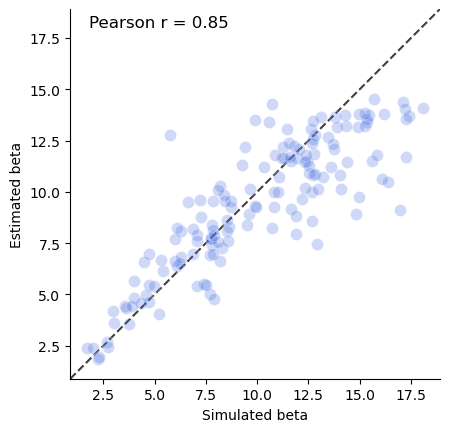

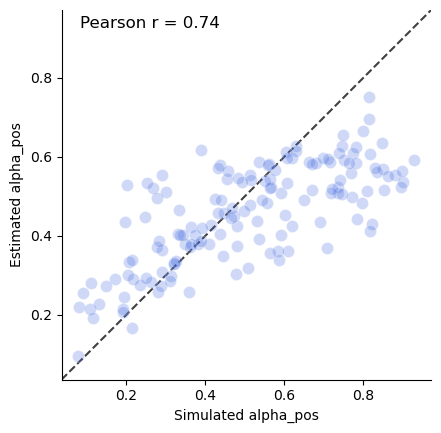

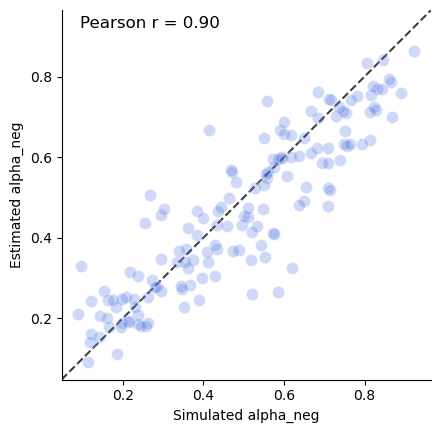

In [33]:
# show parameter recovery
import matplotlib.pyplot as plt
for param_idx, param_label in enumerate(['beta','alpha_pos','alpha_neg']):
    simulated_param = sim['params'][:,param_idx]
    fitted_params = modfit_dict['est_params'][:,param_idx]
    ax = plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

In [ ]:
model = EMModel(all_data=all_data, fit_func=rw_fit, param_names=['beta','lr'])
res = model.fit(mstep_maxit=100, njobs=-1, optim_method='BFGS', max_restarts=2)

In [39]:
print(res.convergence, res.posterior_mu, res.posterior_sigma)

True [-0.32267819  0.1395459 ] [0.73900846 0.70945474]


In [34]:
# two fits to compare (example)
from pyem.core.compare import compare_models

m1 = EMModel(all_data=all_data, fit_func=rw1a1b_fit, param_names=["beta","alpha"])
m2 = EMModel(all_data=all_data, fit_func=rw2a1b_fit, param_names=["beta","alpha_pos","alpha_neg"])
r1 = m1.fit(mstep_maxit=50, verbose=0)
r2 = m2.fit(mstep_maxit=50, verbose=0)

In [35]:
rows = compare_models(
    [("RW-1", r1.__dict__, all_data, rw_fit),
     ("RW-2", r2.__dict__, all_data, rw_fit)],
    bicint_kwargs={"nsamples": 2000, "func_output": "all", "nll_key": "CHOICE_NLL"},
    r2_kwargs={"ntrials": 6*24, "nopts": 2}
)

In [37]:
rows

[ComparisonRow(name='RW-2', LME=-5037.498839789264, BICint=None, R2=np.float64(0.6963617559629929)),
 ComparisonRow(name='RW-1', LME=-5168.347994910305, BICint=None, R2=np.float64(0.6824410119514083))]

In [ ]:
from pyem.core.posterior import posterior_predictive_check

def stat_fn(all_data):  # e.g., mean reward
    import numpy as np
    return float(np.mean([r for _, r in all_data]))

def assemble(sim):
    
    return [[c, r] for c, r in zip(sim["choices"], sim["rewards"])]

ppc = posterior_predictive_check(
    simulate_func=rw2a1b_simulate,
    fit_result=r2.__dict__,
    all_data=all_data,
    stat_fn=stat_fn,
    n_sims=1000,
    assemble_data=assemble
)
print(ppc.p_value)


0.08591408591408592
